# VAE with Pytorch for Adult.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics # plot_roc_curve.
from sklearn.model_selection import train_test_split # Train/test/validation split of data.
import sklearn.preprocessing as preprocessing
import random 

# Pytorch imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader 

# Configure the device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using '{device}' device.")

# Print working directory (for control)
import os
print(f"The working directory is {os.getcwd()}")

# Set seeds for reproducibility. 
seed = 1234
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

Using 'cuda' device.
The working directory is /home/ajo/gitRepos/master_thesis


In [27]:
# Load the adult data. 
adult_data = pd.read_csv("adult_data_no_NA.csv", index_col = 0)
print(adult_data.shape) # Looks good!

categorical_features = ["workclass","marital_status","occupation","relationship", \
                        "race","sex","native_country"]
numerical_features = ["age","fnlwgt","education_num","capital_gain","capital_loss","hours_per_week"]

(45222, 14)


In [28]:
# %load Data.py
# Classes for data.

import sklearn.preprocessing as preprocessing
from sklearn.model_selection import train_test_split 
from torch.utils.data import Dataset
import numpy as np
import torch


class Data():
    """Class for pre-processing data. It automatically encodes, splits and scales the data. 
    
    Contains methods for standardization, encoding and train/test/validation splitting.
    
    Parameters
    ----------
    data : dataframe
        Pandas df with loaded data. 
    cat_features : list of strings.
        List of categorical features. 
    num_features : list of string. 
        List of numerical features. 
    valid : Boolean 
        True if validation data should be made, False if not. 
        
    Methods 
    -------
    get_training_data :
        Returns a tuple with training data (X,y).
    get_test_data :
        Returns a tuple with test data (X,y).   
    get_validation_data :
        Returns a tuple with validation data (X,y) (if applicable).
    train_test_valid_split : 
        Returns a tuple with (X_train, y_train, X_test, y_test) or 
        (X_train, y_train, X_test, y_test, X_valid, y_valid).
    scale : 
        Scale the numerical features according to X_train.
    descale : 
        Descale the numerical features according to X_train.
    fit_scaler :
        Fit sklearn scaler to X_train.
    encode :
        Encode the categorical features according to X_train.
    decode :
        Decode the categorical features according to X_train.
    fit_encoder :
        Fit sklearn encoder to X_train.
        
    """
    def __init__(self, data, cat_features, num_features, valid = False):
        # The transformations are then done here. 
        self._data = data
        self.categorical_features = cat_features
        self.numerical_features = num_features
        self.valid = valid
        
        # Assume output always is called 'y'.
        self._X = data.loc[:, data.columns != "y"]
        self._y = data.loc[:,"y"] 
        
        # Encode the categorical features. 
        self.encoder = self.fit_encoder() # Fit the encoder to the categorical data.
        self.X_encoded = self.encode()
        
        # Split into train/test/valid.
        if self.valid:
            (self.X_train, self.y_train, self.X_test, self.y_test, \
                self.X_valid, self.y_valid) = self.train_test_valid_split(self.X_encoded, self._y)
        else:
            (self.X_train, self.y_train, self.X_test, self.y_test) = self.train_test_valid_split(self.X_encoded, self._y)
        
        # Scale the numerical features. 
        self.scaler = self.fit_scaler()
        self.X_train_scaled = self.scale(self.X_train) # Scale the training data.
        self.X_test_scaled = self.scale(self.X_test) # Scale the test data.
        if self.valid:
            self.X_valid_scaled = self.scale(self.X_valid) # Scale the validation data. 
        
    def get_training_data_preprocessed(self):
        """Returns preprocessed training data (X_train, y_train)."""
        return self.X_train_scaled, self.y_train

    def get_training_data(self):
        """Returns training data before preprocessing (X_train_og, y_train)."""
        X_train_og = self.decode(self.X_train)
        return X_train_og, self.y_train
    
    def get_test_data_preprocessed(self):
        """Returns preprocessed test data (X_test, y_test)."""
        return self.X_test_scaled, self.y_test

    def get_test_data(self):
        """Returns test data before preprocessing (X_test_og, y_test)."""
        X_test_og = self.decode(self.X_test)
        return X_test_og, self.y_test
    
    def get_validation_data_preprocessed(self):
        """Returns preprocessed validation data (X_valid, y_valid)."""
        if self.valid:
            return self.X_valid_scaled, self.y_valid
        else: 
            raise ValueError("You did not instantiate this object to contain validation data.")

    def get_validation_data(self):
        """Returns validation data before preprocessing (X_valid_og, y_valid) if applicable."""
        X_valid_og = self.decode(self.X_valid)
        if self.valid:
            return X_valid_og, self.y_valid
        else: 
            raise ValueError("You did not instantiate this object to contain validation data.")
    
    def train_test_valid_split(self, X, y):
        """Split data into training/testing/validation, where validation is optional at instantiation."""
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)
        if self.valid:
            X_test, X_valid, y_test, y_valid = train_test_split( \
                                        X_test, y_test, test_size=1/3, random_state=42)
            return (X_train, y_train, X_test, y_test, X_valid, y_valid)
        return (X_train, y_train, X_test, y_test)
            
    def scale(self, df):
        """Scale the numerical features according to the TRAINING data."""
        output = df.copy() # Deep copy the given df. 
        output[self.numerical_features] = self.scaler.transform(output[self.numerical_features])
        return output
        
    def descale(self, df):
        """Descale the numerical features according to the TRAINING data."""
        output = df.copy()
        output[self.numerical_features] = self.scaler.inverse_transform(output[self.numerical_features])
        return output

    def fit_scaler(self):
        """Fit the scaler to the numerical TRAINING data. Only supports OneHotEncoding."""
        return preprocessing.StandardScaler().fit(self.X_train[self.numerical_features])
    
    def encode(self):
        """Encode the categorical data. Only supports OneHotEncoding."""
        output = self._X.copy() # Deep copy the X-data.
        encoded_features = self.encoder.get_feature_names(self.categorical_features) # Get the encoded names. 
        
        # Add the new columns to the new dataset (all the levels of the categorical features).
        output[encoded_features] = self.encoder.transform(output[self.categorical_features])

        # Remove the old columns (before one-hot encoding)
        output = output.drop(self.categorical_features, axis = 1) 
        return output
    
    def decode(self, df):
        """Decode the categorical data. Only support OneHotEncoding."""
        output = df.copy()
        encoded_features = self.encoder.get_feature_names(self.categorical_features) # Get the encoded names. 
        
        if len(encoded_features) == 0:
            return output # Does not work when there are not categorical features in df.
        
        output[self.categorical_features] = self.encoder.inverse_transform(output[encoded_features])
        output = output.drop(encoded_features, axis=1)
        return output[self._X.columns] # Reorder the columns to match the original order of the dataframe. 
    
    def fit_encoder(self):
        """Fit the encoder to the categorical data. Only supports OneHotEncoding."""
        return preprocessing.OneHotEncoder(handle_unknown = "error", \
          sparse = False, drop = None).fit(self._X[self.categorical_features])

class CustomDataset(Dataset):
    """Class for using data with Pytorch."""
    def __init__(self, X, y, transform = None):
        self.X = X.values.astype(np.float32) # Return a Numpy array with the dataframe contents. 
        self.y = np.reshape(y.values,(len(y.values),1)).astype(np.float32) # Return a Numpy array with the dataframe contents. 

        self.n_samples = self.X.shape[0]
        self.transform = transform
       
    def __getitem__(self, index):
        sample = self.X[index], self.y[index]
        if self.transform:
            sample = self.transform(sample)
        return sample
   
    def __len__(self):
        return self.n_samples
    
class ToTensor:
    """Callable object to transform CustomDataset inputs and labels to Pytorch tensors."""
    def __call__(self, sample):
        inputs, labels = sample
        return torch.from_numpy(inputs), torch.from_numpy(labels)


In [29]:
# Time to test the class out. 
Adult = Data(adult_data, categorical_features, numerical_features, valid = True)
X_train, y_train = Adult.get_training_data_preprocessed()
X_test, y_test = Adult.get_test_data_preprocessed()
X_valid, y_valid = Adult.get_validation_data_preprocessed()
#print(X_train.shape)
#print(X_test.shape)
#print(X_valid.shape)

# Test descaling the already scaled data sets.
X_train_descaled = Adult.descale(X_train)
#print(X_train_descaled.shape)
#print(X_train_descaled[numerical_features].describe())

# Test decoding from one-hot encoding.
X_train_decoded = Adult.decode(X_train)
#print(X_train_decoded.shape)
#print(X_train_decoded[categorical_features].describe())

# Decoded and descaled data set should be the same as original (training) data. 
X_train_descaled = Adult.descale(X_train)
X_train_de_everything = Adult.decode(X_train_descaled)
print(X_train_de_everything[categorical_features].describe())
print(X_train_de_everything[numerical_features].describe())
print(X_train_de_everything.shape)
# Looks like it all works as I intended!

       workclass       marital_status       occupation relationship    race  \
count      30148                30148            30148        30148   30148   
unique         7                    7               14            6       5   
top      Private   Married-civ-spouse   Prof-specialty      Husband   White   
freq       22151                14080             4050        12504   25931   

          sex  native_country  
count   30148           30148  
unique      2              40  
top      Male   United-States  
freq    20386           27533  
               age        fnlwgt  education_num  capital_gain  capital_loss  \
count  30148.00000  3.014800e+04   30148.000000  30148.000000  30148.000000   
mean      38.54249  1.896485e+05      10.124453   1091.022788     87.993200   
std       13.24241  1.059980e+05       2.565913   7519.182124    403.737188   
min       17.00000  1.349200e+04       1.000000      0.000000      0.000000   
25%       28.00000  1.172680e+05       9.000000  

## The Dataset class for Pytorch below takes some data constructed from the Data class  

This is loaded from the Data class file above. 

## Time to implement the VAE

We base our initial implementation on: https://github.com/jmtomczak/intro_dgm/blob/main/vaes/vae_example.ipynb
It is somewhat modified by me. 

In [30]:
# Probability distributions.
PI = torch.from_numpy(np.asarray(np.pi))
EPS = 1.e-5

def log_normal_diag(x, mu, log_var, reduction=None, dim=None):
    """Log-normal probability distribution."""
    D = x.shape[1]
    log_p = -0.5 * D * torch.log(2. * PI) - 0.5 * log_var - 0.5 * torch.exp(-log_var) * (x - mu)**2.
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p
    
def log_standard_normal(x, reduction=None, dim=None):
    """Log standard Gaussian distribution."""
    D = x.shape[1]
    log_p = -0.5 * D * torch.log(2. * PI) - 0.5 * x**2.
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

In [31]:
class Encoder(nn.Module):
    def __init__(self, input_size, latent_size):
        super(Encoder, self).__init__()
        
        # Initialize the encoder net. Very simple with only one hidden layer with 15 units. 
        # Could make this arbitrarily more complex later. 
        self.encoder = nn.Sequential(nn.Linear(input_size, 15), nn.ReLU(),
                                    nn.Linear(15, 2*latent_size))
    
    @staticmethod
    def reparameterization(mu, log_var):
        """Reparameterization trick for Gaussian distributions."""
        std = torch.exp(0.5*log_var) # Get std from log_var.
        eps = torch.randn_like(std) # Sample eps from N(0,1).
        return mu + std * eps # Return sample from N(mu, std^2).

    def encode(self, x):
        """Encodes x, i.e. returns mu and log_var based on x."""
        h_e = self.encoder(x) # Encode x. Returns 2*hidden dim tensor. 
        mu_e, log_var_e = torch.chunk(h_e, 2, dim = 1) # Splits encoded tensor in two.
        return mu_e, log_var_e
    
    def sample(self, x=None, mu_e=None, log_var_e=None):
        """Samples from the encoder based on x. Returns a latent sample."""
        if (mu_e is None) and (log_var_e is None): # None supplied.
            mu_e, log_var_e = self.encode(x) # Calculate mu and log_var if not provided. 
        else:
            if (mu_e is None) or (log_var_e is None): # Both need to be supplied, not only one.
                raise ValueError("'mu' and 'log_var' cannot be None.")
        z = self.reparameterization(mu_e, log_var_e)
        return z
    
    def log_prob(self, x=None, mu_e=None,log_var_e=None, z=None):
        """Calculates log-probability."""
        if x is not None: # If x is supplied, we do not need the other arguments. 
            mu_e, log_var_e = self.encode(x)
            z = self.sample(mu_e=mu_e, log_var_e=log_var_e)
        else:
            # If x is not supplied, mu_e, log_var and z need to be supplied.
            if (mu_e is None) or (log_var_e is None) or (z is None):
                raise ValueError("'mu', 'log_var' and 'z' cannot be None.")
        return log_normal_diag(z, mu_e, log_var_e)
    
    def forward(self, x, type="log_prob"):
        """Forward pass for training. Returns either log-prob or sampling."""
        assert type in ["encode", "log_prob"], "Type could be either 'encode' or 'log_prob'."
        if type == "log_prob":
            return self.log_prob(x)
        else:
            return self.sample(x)

In [32]:
class Decoder(nn.Module):
    def __init__(self, output_size, latent_size, distribution="gaussian", num_vals = None):
        super(Decoder, self).__init__()
        
        self.distribution = distribution # We only implement it for Gaussian (replicating our project).
        self.num_vals = num_vals # This is needed for the categorical distribution.
                                 # Thus it is not interesting for us now.
        
        # Initialize the decoder net. Very simple with only one hidden layer with 15 units. 
        # Could make this arbitrarily more complex later. 
        self.decoder = nn.Sequential(nn.Linear(latent_size, 15), nn.ReLU(),
                                    nn.Linear(15, output_size))
    
    def decode(self, z):
        """Decode a sample z from the latent space. Returns mu, i.e. necessary parameter for p(x|z)."""
        h_d = self.decoder(z)
        if self.distribution == "categorical":
            pass
        elif self.distribution == "bernoulli":
            pass
        elif self.distribution == "gaussian":
            # With the Gaussian we simply return the linear output.
            return [h_d]
        else: 
            raise ValueError("Only 'gaussian' decoder distribution is implemented.")
    
    def sample(self, z):
        """Returns a reconstructed sample in the input space, based on latent sample z."""
        out = self.decode(z)
        if self.distribution == "categorical":
            pass
        elif self.distribution == "bernoulli":
            pass
        elif self.distribution == "gaussian":
            mu_d = out[0]
            x_new = torch.normal(mu_d, torch.full_like(mu_d,np.sqrt(2))) # Try to replicate the same as in the project.
        else:
            raise ValueError("Only 'gaussian' decoder distribution is implemented.")
        return x_new
    
    def log_prob(self, x, z):
        """Calculated log-probability."""
        out = self.decode(z)
        if self.distribution == "categorical":
            pass
        elif self.distribution == "bernoulli":
            pass
        elif self.distribution == "gaussian":
            mu_d = out[0]
            log_p = log_normal_diag(x, mu_d, torch.full_like(mu_d,np.log(2)),reduction = "sum", dim = -1)
        else: 
            raise ValueError("Only 'gaussian' decoder distribution is implemented.")
        return log_p
    
    def forward(self, z, x, type = "log_prob"):
        """Forward pass."""
        assert type in ['decoder', 'log_prob'], "Type could be either 'decode' or 'log_prob'"
        if type == "log_prob":
            return self.log_prob(x, z)
        else:
            return self.sample(x)
        

In [33]:
class Prior(nn.Module):
    """Prior for the latent variables. Standard Gaussian for a simple implementation."""
    def __init__(self, dim):
        super(Prior, self).__init__()
        self.dim = dim
        
    def sample(self,batch_size):
        """Samples from the standard Gaussian."""
        return torch.randn((batch_size, self.dim))
        
    def log_prob(self, z):
        """Calculates log-probability of the prior."""
        return log_standard_normal(z)

In [34]:
class VAE(nn.Module):
    def __init__(self, input_size, latent_size, num_vals, likelihood_type = "gaussian"):
        super(VAE, self).__init__()
        
        self.encoder = Encoder(input_size, latent_size).to(device)
        self.decoder = Decoder(input_size, latent_size, \
                               distribution = likelihood_type, num_vals = num_vals).to(device)
        self.prior = Prior(latent_size).to(device)
        
        self.num_vals = num_vals
        self.likelihood_type = likelihood_type
        
    def forward(self, x, reduction = "avg"):
        """Forward pass for Pytorch."""
        mu_e, log_var_e = self.encoder.encode(x)
        z = self.encoder.sample(mu_e=mu_e, log_var_e=log_var_e)

        # Calculate ELBO.
        RE = self.decoder.log_prob(x, z)
        KL = (self.prior.log_prob(z) - self.encoder.log_prob(mu_e=mu_e, log_var_e=log_var_e, z=z)).sum(-1)
                
        if reduction == "sum":
            return -(RE+KL).sum()
        else:
            return -(RE+KL).mean()

    def sample(self, batch_size = 64):
        """Sample from the VAE using method 4 in my project (sample from latent prior and decode)."""
        z = self.prior.sample(batch_size = batch_size).to(device)
        return self.decoder.sample(z)

In [35]:
# Load data.
batch_size = 16

train_data = CustomDataset(X_train, y_train, transform = ToTensor()) 
test_data = CustomDataset(X_test, y_test, transform = ToTensor()) 

In [36]:
#from pytorch_model_summary import summary
# Hyperparameters. 
input_size = X_train.shape[1]
latent_size = 8

learning_rate = 0.001
num_epochs = 5

# Initialize a VAE model.
vae_model = VAE(input_size, latent_size, 1).to(device)
#print(summary(vae_model))
print(vae_model)

optimizer = torch.optim.Adam(vae_model.parameters(), lr=learning_rate)  

VAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=88, out_features=15, bias=True)
      (1): ReLU()
      (2): Linear(in_features=15, out_features=16, bias=True)
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=8, out_features=15, bias=True)
      (1): ReLU()
      (2): Linear(in_features=15, out_features=88, bias=True)
    )
  )
  (prior): Prior()
)


In [37]:
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 2)

n_total_steps = len(train_loader) # Total length of training data. 
train_losses = []
# Main training loop. 
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader): 
        # Load the data on to the gpu.
        inputs = inputs.to(device)
        labels = labels.view(labels.shape[0],1).to(device) 
        
        # Forward pass.
        #outputs = vae_model(inputs)
        loss = vae_model.forward(inputs)
        
        # Backward and optimize.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 500 == 0:
            train_losses.append(loss.item())
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch [1/5], Step [500/1885], Loss: 7148.9194
Epoch [1/5], Step [1000/1885], Loss: 7149.0488
Epoch [1/5], Step [1500/1885], Loss: 7149.3770
Epoch [2/5], Step [500/1885], Loss: 7148.9453
Epoch [2/5], Step [1000/1885], Loss: 7148.6523
Epoch [2/5], Step [1500/1885], Loss: 7148.5630
Epoch [3/5], Step [500/1885], Loss: 7148.7949
Epoch [3/5], Step [1000/1885], Loss: 7149.3604
Epoch [3/5], Step [1500/1885], Loss: 7151.2036
Epoch [4/5], Step [500/1885], Loss: 7148.5469
Epoch [4/5], Step [1000/1885], Loss: 7148.8140
Epoch [4/5], Step [1500/1885], Loss: 7148.9951
Epoch [5/5], Step [500/1885], Loss: 7148.8979
Epoch [5/5], Step [1000/1885], Loss: 7148.5781
Epoch [5/5], Step [1500/1885], Loss: 7148.5088


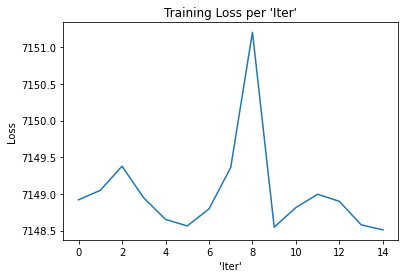

In [38]:
plt.plot(train_losses)
plt.title("Training Loss per 'Iter'")
plt.xlabel("'Iter'")
plt.ylabel("Loss")
plt.show()

In [39]:
# We need to try to generate some data from the VAE next. 
with torch.no_grad():
    x_synth = vae_model.sample(30000) # Sample synthetic data. 
    x_synth = x_synth.cpu().numpy() # Change to cpu and convert to numpy 2D array. 
    df_synth = pd.DataFrame(x_synth, columns = X_test.columns) # Make dataframe of synthetic data. 

In [40]:
X_test.describe()
X_test_decoded = Adult.decode(X_test)
X_test_decoded = Adult.descale(X_test_decoded)

In [41]:
X_test_decoded.describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,10049.000000,1.004900e+04,10049.000000,10049.000000,10049.000000,10049.000000
mean,38.529704,1.892961e+05,10.106080,1121.994328,94.209474,40.930043
std,13.176500,1.056462e+05,2.525525,7464.602533,417.381500,12.115749
min,17.000000,1.984700e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.173100e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.772650e+05,10.000000,0.000000,0.000000,40.000000
75%,47.000000,2.366840e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.268339e+06,16.000000,99999.000000,3770.000000,99.000000


In [42]:
print("Test data (real)")
summer = 0
for feat in categorical_features:
    unq = len(X_test_decoded[feat].value_counts().keys().unique())
    print(f"Feature '{feat}' has {unq} unique levels")
    summer += unq
print(f"The sum of all levels is {summer}. This will be the number of cat-columns after one-hot encoding (non-full rank)")
# More interesting would be to print the number in each level!
# But we might as well check if all the levels exist in the synthetic data anyway.

X_test_decoded["sex"].value_counts()

Test data (real)
Feature 'workclass' has 7 unique levels
Feature 'marital_status' has 7 unique levels
Feature 'occupation' has 14 unique levels
Feature 'relationship' has 6 unique levels
Feature 'race' has 5 unique levels
Feature 'sex' has 2 unique levels
Feature 'native_country' has 39 unique levels
The sum of all levels is 80. This will be the number of cat-columns after one-hot encoding (non-full rank)


 Male      6735
 Female    3314
Name: sex, dtype: int64

In [43]:
df_synth.describe()
df_synth_decoded = Adult.decode(df_synth)
df_synth_decoded = Adult.descale(df_synth_decoded)
df_synth_decoded.describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,38.008545,188709.890625,10.153239,1063.692627,92.013969,40.663651
std,18.852659,149085.093750,3.640542,10691.316406,570.322754,16.903114
min,-39.279041,-402974.968750,-5.544599,-46951.882812,-2376.306885,-32.704155
25%,25.313559,88232.603516,7.702278,-6150.372070,-293.204224,29.198905
50%,38.113424,189703.750000,10.146426,1147.105896,93.908348,40.650749
75%,50.650681,289205.835938,12.592126,8326.157227,476.573219,52.207498
max,115.080193,850431.937500,24.838003,46832.382812,2662.523193,108.386154


In [44]:
print("Synthetic data")
summer = 0
for feat in categorical_features:
    unq = len(df_synth_decoded[feat].value_counts().keys().unique())
    print(f"Feature '{feat}' has {unq} unique levels")
    summer += unq
print(f"The sum of all levels is {summer}. This will be the number of cat-columns after one-hot encoding (non-full rank)")
# More interesting would be to print the number in each level!
# But we might as well check if all the levels exist in the synthetic data anyway.

df_synth_decoded["sex"].value_counts()

Synthetic data
Feature 'workclass' has 7 unique levels
Feature 'marital_status' has 7 unique levels
Feature 'occupation' has 14 unique levels
Feature 'relationship' has 6 unique levels
Feature 'race' has 5 unique levels
Feature 'sex' has 2 unique levels
Feature 'native_country' has 41 unique levels
The sum of all levels is 82. This will be the number of cat-columns after one-hot encoding (non-full rank)


 Male      17145
 Female    12855
Name: sex, dtype: int64

## Plots for comparison

It looks like the VAE sucks for now (not surprising as the loss function does not really decrease during training!). 

We make some plots that can be used to compare the synthetic and the original data sets (as done in R earlier).

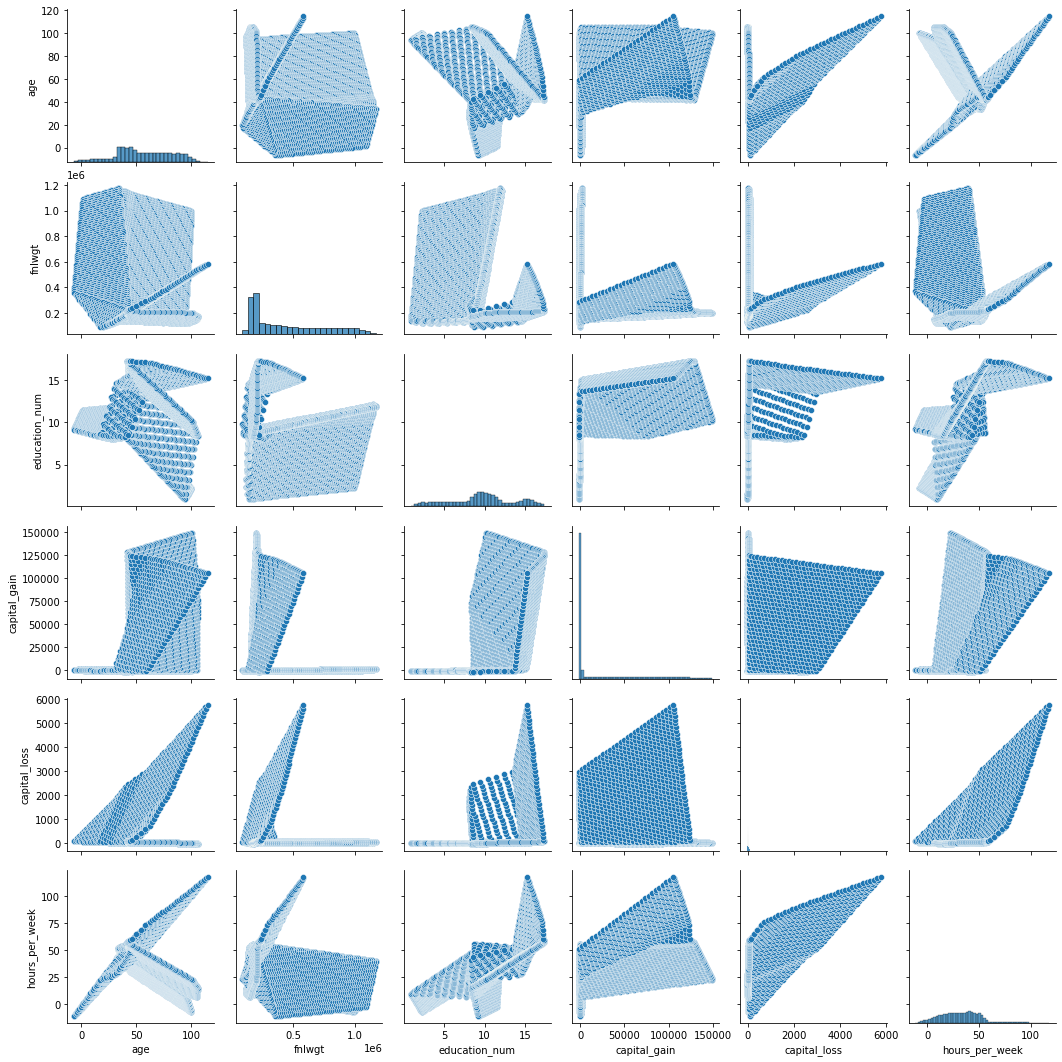

In [3]:
# I just did some testing below while developing ae.py (as a beginning of vae.)
synthetic = pd.read_csv("synth_ae.csv", index_col = 0)
synthetic.describe()
import seaborn as sbs
sbs.pairplot(synthetic)

In [46]:
Adult = Data(adult_data, categorical_features, numerical_features, valid = True)

# Load the preprocessed data. 
X_train_prep, y_train = Adult.get_training_data_preprocessed()
X_test_prep, y_test = Adult.get_test_data_preprocessed()
X_valid_prep, y_valid = Adult.get_validation_data_preprocessed()

# Load the original data to have for later. 
X_train_og, _  = Adult.get_training_data()
X_test_og, _  = Adult.get_test_data()
X_valid_og, _ = Adult.get_validation_data()

X_train_og.info()
X_train_og.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30148 entries, 31422 to 17056
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             30148 non-null  int64 
 1   workclass       30148 non-null  object
 2   fnlwgt          30148 non-null  int64 
 3   education_num   30148 non-null  int64 
 4   marital_status  30148 non-null  object
 5   occupation      30148 non-null  object
 6   relationship    30148 non-null  object
 7   race            30148 non-null  object
 8   sex             30148 non-null  object
 9   capital_gain    30148 non-null  int64 
 10  capital_loss    30148 non-null  int64 
 11  hours_per_week  30148 non-null  int64 
 12  native_country  30148 non-null  object
dtypes: int64(6), object(7)
memory usage: 3.2+ MB


,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,30148.00000,3.014800e+04,30148.000000,30148.000000,30148.000000,30148.000000
mean,38.54249,1.896485e+05,10.124453,1091.022788,87.993200,40.939697
std,13.24241,1.059980e+05,2.565913,7519.182124,403.737188,12.015423
min,17.00000,1.349200e+04,1.000000,0.000000,0.000000,1.000000
25%,28.00000,1.172680e+05,9.000000,0.000000,0.000000,40.000000
50%,37.00000,1.782450e+05,10.000000,0.000000,0.000000,40.000000
75%,47.00000,2.378410e+05,13.000000,0.000000,0.000000,45.000000
max,90.00000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


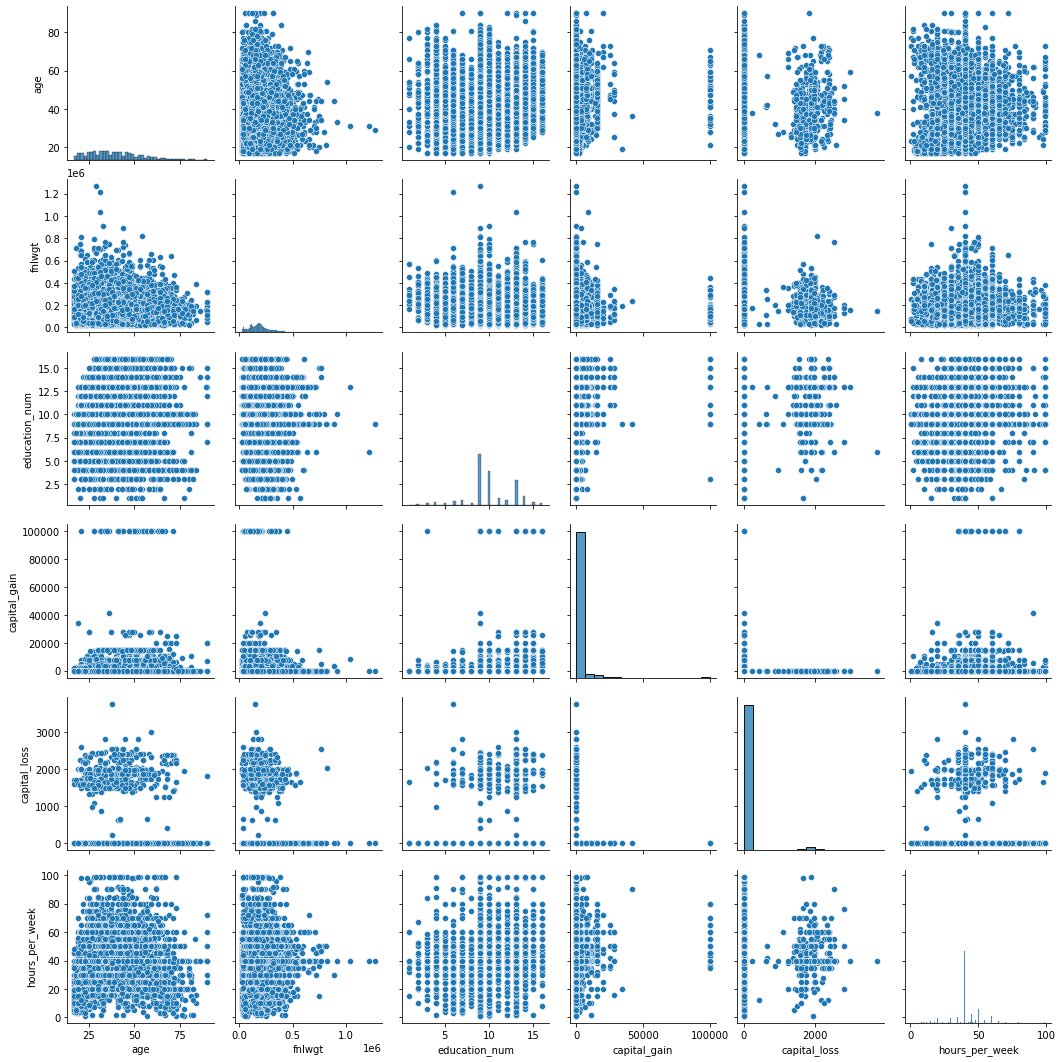

In [47]:
sbs.pairplot(X_test_og)